In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import random
sns.set()
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import accuracy_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
np.random.seed(1)
from calendar import monthrange


# Importante

Para las redes neuronales estamos usandos Keras, el cual requiere de tensorflow en el back para poder usarse. Antes de correr ciertos algoritmos se deberá tener configurado el entorno.


pip install keras

pip install tensorflow

pip install pmdarima


Primero leemos los dataset por separado. Luego pasamos a dividir el problema en 5 partes: La primera y segunda será sobre la demanda donde se estudiará el consumo total del pais por horas y luego por dias, la tercera y cuarta lo mismo pero con los datos de produccion y la quitan será buscar relacion entre la demanda y la produccion incluyendo eventos que afecten a estos datos. 
Ademas de varias modificaciones que se harán a los dataset con el fin de adaptarlo a cada parte

In [2]:
datosDemandaBruto = pd.read_csv("Demand13.csv")
datosProduccionBruto = pd.read_csv("Supply13.csv")

In [3]:
print(datosDemandaBruto)
datosDemandaBruto.head()

       Hours  Baghdad  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1     3294   1243     757          488    471    598    525    514   
1          2     2973   1151     753          477    436    570    500    469   
2          3     2758   1105     727          471    419    604    478    430   
3          4     2703   1220     717          470    463    564    497    465   
4          5     2954   1358     751          519    515    626    553    517   
...      ...      ...    ...     ...          ...    ...    ...    ...    ...   
26347     20     4894   1906    1206         1008    912   1112   1112    914   
26348     21     4550   1798    1158          928    862   1047   1027    869   
26349     22     4326   1683    1091          868    818   1001    972    807   
26350     23     4090   1567     988          819    782    935    892    780   
26351     24     3954   1465     942          780    750    879    838    728   

       Najaf  Dywan.  Wasit

,Hours,Baghdad,Nynwa,Kirkuk,Slah El-Din,Anbar,Dyala,Babil,Kerb.,Najaf,Dywan.,Wasit,Muthnna,Thi-Qar,Mesan,Basrah
0,1,3294,1243,757,488,471,598,525,514,474,307,404,208,573,369,1254
1,2,2973,1151,753,477,436,570,500,469,437,284,374,193,536,342,1100
2,3,2758,1105,727,471,419,604,478,430,420,273,359,185,519,328,1056
3,4,2703,1220,717,470,463,564,497,465,451,301,397,204,522,363,1100
4,5,2954,1358,751,519,515,626,553,517,502,335,442,228,574,404,1298


In [4]:
print(datosProduccionBruto)
datosProduccionBruto.head()

       Hours  Bagh.  Nynwa  Kirkuk  Slah El-Din  Anbar  Dyala  Babil  Kerb.  \
0          1   3294    740     668          488    394    598    525    514   
1          2   2973    751     753          477    387    570    500    469   
2          3   2758    760     727          471    374    604    478    430   
3          4   2703    759     717          470    365    546    490    433   
4          5   2794    727     751          470    374    578    539    472   
...      ...    ...    ...     ...          ...    ...    ...    ...    ...   
26347     20   3364    765     762          418    421    587    648    608   
26348     21   3437    748     751          412    418    617    678    638   
26349     22   3368    761     751          420    411    603    719    689   
26350     23   3373    801     782          424    406    614    663    681   
26351     24   3169    853     759          422    404    604    568    593   

       Najaf  Dywan.  Wasit  Muthnna  Thi-Qar  Mesa

,Hours,Bagh.,Nynwa,Kirkuk,Slah El-Din,Anbar,Dyala,Babil,Kerb.,Najaf,Dywan.,Wasit,Muthnna,Thi-Qar,Mesan,Basrah
0,1,3294,740,668,488,394,598,525,514,474,246,397,185,573,294,1104
1,2,2973,751,753,477,387,570,500,469,437,223,362,177,536,269,1030
2,3,2758,760,727,471,374,604,478,430,420,210,347,169,519,229,956
3,4,2703,759,717,470,365,546,490,433,420,202,350,172,522,232,953
4,5,2794,727,751,470,374,578,539,472,449,246,389,191,574,275,1003


Para el total de horas sumaremos el valor de todas las columna, ya que cada columna representa el valor de cada provincia, creando una nueva columna con esto mismo.

In [5]:
datosDemandaTotalHoras = pd.DataFrame()
datosProduccionTotalHoras = pd.DataFrame()

In [6]:
datosDemandaTotalHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [7]:
datosDemandaTotalHoras["Hours"] = datosDemandaBruto["Hours"]
datosProduccionTotalHoras["Hours"] = datosProduccionBruto["Hours"]

In [8]:
datosDemandaTotalSinHoras = pd.DataFrame()
datosProduccionTotalSinHoras = pd.DataFrame()

In [9]:
datosDemandaTotalSinHoras["total"] = datosDemandaBruto.iloc[:, 1:].sum(axis=1)
datosProduccionTotalSinHoras["total"] = datosProduccionBruto.iloc[:, 1:].sum(axis=1)

In [10]:
datosDemandaTotalHoras.head()


,total,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5


In [11]:
datosDemandaTotalSinHoras.head()

,total
0,11479
1,10595
2,10132
3,10437
4,11576


Ahora partimos de un nuevo dataset el cual tiene una columna con las demanda/produccion por horas, es decir cada fila es una hora y cada 24 filas es un día. Una vez tenemos estos dos dataset, vamos a pasar estas horas a dias para tener los otros dos dataset faltantes.

In [12]:
suma_24_demanda = []
suma_24_produccion = []

In [13]:
for i in range(0, len(datosDemandaTotalSinHoras), 24):
    end = i + 24
    if end > len(datosDemandaTotalSinHoras):
        end = len(datosDemandaTotalSinHoras)
    suma_24_demanda.append(datosDemandaTotalSinHoras[i:end].sum(axis=0).sum())

In [14]:
for i in range(0, len(datosProduccionTotalSinHoras), 24):
    end = i + 24
    if end > len(datosProduccionTotalSinHoras):
        end = len(datosProduccionTotalSinHoras)
    suma_24_produccion.append(datosProduccionTotalSinHoras[i:end].sum(axis=0).sum())

In [15]:
datosDemandaTotalDias = pd.DataFrame({'Total': suma_24_demanda})
datosProduccionTotalDias = pd.DataFrame({'Total': suma_24_produccion})

In [16]:
diasDemanda = pd.date_range(start='2019-01-01', periods=len(suma_24_demanda), freq='D')
diasProduccion = pd.date_range(start='2019-01-01', periods=len(suma_24_produccion), freq='D')

In [17]:
datosDemandaTotalDias["fecha"] = diasDemanda
datosProduccionTotalDias["fecha"] = diasProduccion

Despues de hacer todas estas transformaciones ya tenemos los 4 dataset que queremos: datosDemandaTotalHoras/datosProduccionTotalHoras los cuales tiene la produccion total por ahora y datosDemandaTotalDias/datosProduccionTotalDias los cuales tienen la produccion por dias

In [18]:
datosDemandaTotalHoras.head()


,total,Hours
0,11479,1
1,10595,2
2,10132,3
3,10437,4
4,11576,5


In [19]:
datosProduccionTotalHoras.head()

,total,Hours
0,10494,1
1,9914,2
2,9452,3
3,9334,4
4,9832,5


In [20]:
datosDemandaTotalDias.head()

,Total,fecha
0,379726,2019-01-01
1,383590,2019-01-02
2,378901,2019-01-03
3,378180,2019-01-04
4,385805,2019-01-05


In [21]:
datosProduccionTotalDias.head()

,Total,fecha
0,289005,2019-01-01
1,288843,2019-01-02
2,283581,2019-01-03
3,285621,2019-01-04
4,283991,2019-01-05


In [22]:
data = pd.merge(datosDemandaTotalDias, datosProduccionTotalDias, on='fecha')

In [23]:
data = data.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})

In [24]:
data = data.set_index('fecha')

In [25]:
data

,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-29,411592,261122
2021-12-30,378184,248905
2021-12-31,414996,257533


In [26]:
estaciones = {
    1: 'Invierno',
    2: 'Invierno',
    3: 'Invierno',
    4: 'Primavera',
    5: 'Primavera',
    6: 'Verano',
    7: 'Verano',
    8: 'Verano',
    9: 'Verano',
    10: 'Otoño',
    11: 'Otoño',
    12: 'Invierno'
}

In [27]:
dataEstacion = data.copy()

In [28]:
dataEstacion['estacion'] = data.index.month.map(estaciones)

In [29]:
dataEstacion.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1098 entries, 2019-01-01 to 2022-01-02
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Demanda     1098 non-null   int64 
 1   Produccion  1098 non-null   int64 
 2   estacion    1098 non-null   object
dtypes: int64(2), object(1)
memory usage: 34.3+ KB


In [30]:
dataEstacion

,Demanda,Produccion,estacion
fecha,,,
2019-01-01,379726,289005,Invierno
2019-01-02,383590,288843,Invierno
2019-01-03,378901,283581,Invierno
2019-01-04,378180,285621,Invierno
2019-01-05,385805,283991,Invierno
...,...,...,...
2021-12-29,411592,261122,Invierno
2021-12-30,378184,248905,Invierno
2021-12-31,414996,257533,Invierno


In [31]:
dataEstacion.groupby(['estacion'])['Demanda'].mean()

estacion
Invierno     368132.762295
Otoño        342338.863388
Primavera    365714.278689
Verano       540844.855191
Name: Demanda, dtype: float64

In [32]:
dataEstacion.groupby(['estacion'])['Produccion'].mean()

estacion
Invierno     268142.710383
Otoño        283917.808743
Primavera    306742.420765
Verano       403776.814208
Name: Produccion, dtype: float64

<AxesSubplot:xlabel='fecha'>

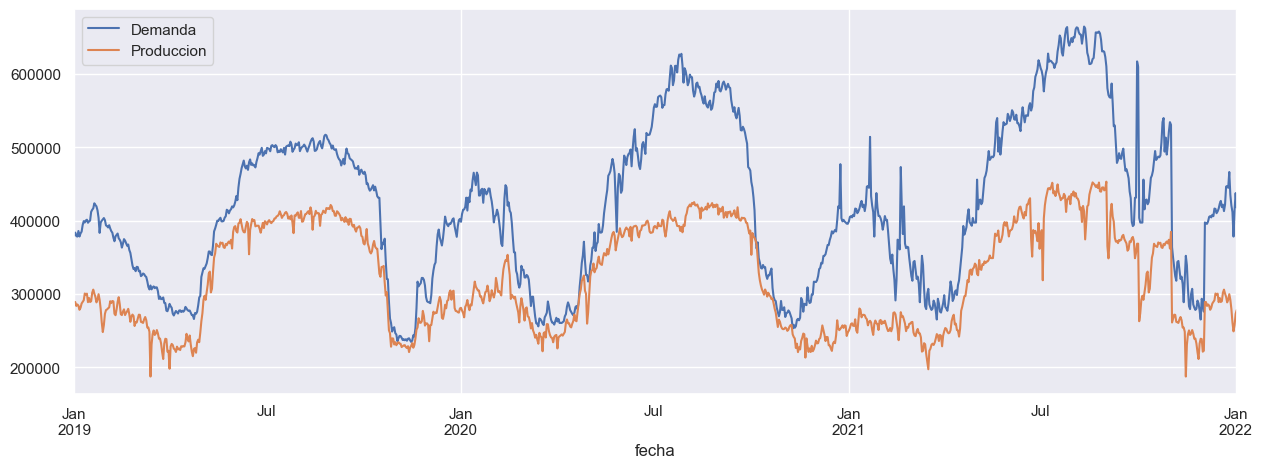

In [33]:
dataEstacion.plot(figsize=(15,5))

# Análisis



Ahora vamos a hacer transformaciones de estos dataset para sacar obtener el dataset final el cual tendrá las columnas de demanda y produccion, tambien cambiaremos el indice a la fecha para trabajar con las series temporales

In [34]:
data = data[data.index < pd.to_datetime("31-12-2021")]

In [35]:
data.info()
data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2019-01-01 to 2021-12-30
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Demanda     1095 non-null   int64
 1   Produccion  1095 non-null   int64
dtypes: int64(2)
memory usage: 25.7 KB


,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246


In [ ]:
dataPreCovid = data[data.index <= pd.to_datetime("23-feb-2020")]
dataPreCovid = dataPreCovid[pd.to_datetime("15-12-2019") <= dataPreCovid.index ]
dataPreCovid

In [ ]:
dataPreCovid.plot(figsize=(15,5))

In [ ]:
dataCovid = data[data.index <= pd.to_datetime("30-04-2020")].copy()
dataCovid = dataCovid[pd.to_datetime("24-02-2020") <= dataCovid.index ]
dataCovid

In [ ]:
dataCovid.plot(figsize=(15,5))

In [ ]:
media_Covid_precovid = pd.DataFrame() 
datosCovid = {'Periodo': ['Pre-Covid','Covid principio'],
        'Media demanda': [dataPreCovid['Demanda'].mean(), dataCovid['Demanda'].mean()],
        'Media produccion': [dataPreCovid['Produccion'].mean(), dataCovid['Produccion'].mean()]}

media_Covid_precovid = pd.DataFrame(datosCovid)
media_Covid_precovid = media_Covid_precovid.set_index('Periodo')
media_Covid_precovid

In [ ]:
media_Covid_precovid.plot(kind="bar")
plt.title("Demanda vs Produccion en el principio de covid y en pre-covid")
plt.xlabel("Periodos")
plt.ylabel("Cuantidad")

In [ ]:
Festivos_Nacionales = ["01-jan-2019" ,"06-jan-2019","01-may-2019","14-jul-2019","03-oct-2019","01-jan-2020" ,"06-jan-2020","01-may-2020","14-jul-2020","03-oct-2020","01-jan-2021" ,"06-jan-2021","01-may-2021","14-jul-2021","03-oct-2021"]
Festivos_Nacionales


In [ ]:
dataFestivo = data[data.index.isin(Festivos_Nacionales)]
dataFestivo


In [ ]:
dataFestivo.plot(figsize=(15,5))

In [ ]:
dataFestivo.plot(kind="bar")
plt.title("Demanda vs Produccion en los dias de festivos nacionales")
plt.xlabel("Dias festivos nacionales")
plt.ylabel("Cuantidad")

In [ ]:
dataTemporadasProduccion = dataEstacion.groupby('estacion').agg(media_produccion=('Produccion','mean')).reset_index()
dataTemporadasProduccion

In [ ]:
dataTemporadasDemanda = dataEstacion.groupby('estacion').agg(media_Demanda=('Demanda','mean')).reset_index()
dataTemporadasDemanda

In [ ]:
dataTemporadas = pd.merge(dataTemporadasDemanda, dataTemporadasProduccion, on='estacion')
dataTemporadas = dataTemporadas.rename(columns={'Total_x': 'Demanda','Total_y': 'Produccion'})
dataTemporadas = dataTemporadas.set_index('estacion')
dataTemporadas

In [ ]:
dataTemporadas.plot(kind="bar")
plt.title("Demanda vs Produccion en las diferentes temporadas")
plt.xlabel("Temporadas")
plt.ylabel("Capacidad media")

# Chaaban vs  Ramadan

In [ ]:
#2019
dataRamadan2019 = data[pd.to_datetime("06-may-2019") <= data.index ]
dataRamadan2019  = dataRamadan2019[dataRamadan2019.index <= pd.to_datetime("04-jun-2019")]

dataShaaban2019 = data[pd.to_datetime("06-apr-2019") <= data.index ]
dataShaaban2019  = dataShaaban2019[dataShaaban2019.index <= pd.to_datetime("05-may-2019")]

#2020
dataRamadan2020 = data[pd.to_datetime("24-apr-2020") <= data.index ]
dataRamadan2020  = dataRamadan2020[dataRamadan2020.index <= pd.to_datetime("23-may-2020")]

dataShaaban2020 = data[pd.to_datetime("25-mar-2020") <= data.index ]
dataShaaban2020  = dataShaaban2020[dataShaaban2020.index <= pd.to_datetime("23-apr-2020")]

#2021
dataRamadan2021 = data[pd.to_datetime("13-apr-2021") <= data.index ]
dataRamadan2021  = dataRamadan2021[dataRamadan2021.index <= pd.to_datetime("12-may-2021")]

dataShaaban2021 = data[pd.to_datetime("14-mar-2021") <= data.index ]
dataShaaban2021  = dataShaaban2021[dataShaaban2021.index <= pd.to_datetime("12-apr-2021")]


In [ ]:
media_Chaaban_Ramadan = pd.DataFrame() 
datos = {'Mes_hijri': ['Shaaban 2019','Ramadan 2019' ,'Shaaban 2020','Ramadan 2020', 'Shaaban 2021','Ramadan 2021'],
        'Media demanda': [dataShaaban2019['Demanda'].mean(), dataRamadan2019['Demanda'].mean(), dataShaaban2020['Demanda'].mean(), dataRamadan2020['Demanda'].mean(), dataShaaban2021['Demanda'].mean(),dataRamadan2021['Demanda'].mean()],
        'Media produccion': [dataShaaban2019['Produccion'].mean(), dataRamadan2019['Produccion'].mean(), dataShaaban2020['Produccion'].mean(), dataRamadan2020['Produccion'].mean(), dataShaaban2021['Produccion'].mean(),dataRamadan2021['Produccion'].mean()]}

media_Shaaban_Ramadan = pd.DataFrame(datos)
media_Shaaban_Ramadan = media_Shaaban_Ramadan.set_index('Mes_hijri')
media_Shaaban_Ramadan

In [ ]:
media_Shaaban_Ramadan.plot(kind="bar")
plt.title("Sha'ban vs Ramadan")
plt.xlabel("Mes hijri")
plt.ylabel("Media")

In [ ]:
data.describe()

Ya de primera podemos observar que vamos a tener dias donde la demanda supera a la produccion, y ademas de media siempre vamos a tener mayor demanda que produccion

In [ ]:
dataMes= data.resample('m').sum()
dataMes

In [ ]:
dataAno = data.resample('y').sum()
dataAno

In [ ]:
data.plot(figsize=(15,5))

In [ ]:
data.plot.box()

Vemos que la produccion nunca abaste la demanda, ademas nos fijamos que en los meses de verano siempre tenemos un pico de demanda que ademas aumenta con los años mientras que la produccion de mantiene

# Dickey-fuller

Vamos a pasar a comprobar si nuestra serie de tiempo es estacionario o no. Para ello vamos a seguir el modelo Dickey-Fuller

In [ ]:
def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Media móvil')
    std = plt.plot(rolstd, color='black', label = 'Desviacion estandar')
    plt.legend(loc='best')
    plt.title('Media móvil & Desviacion estandar')
    plt.show(block=False)
    
    print ('Resultados del Dickey-Fuller Test:')
   
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Estadístico de prueba','p-value','#Lags Used','Numero de observaciones'])
    for key,value in dftest[4].items():
        dfoutput['Valores criticos (%s)'%key] = value
    print(dfoutput)

In [ ]:
adfullerDemanda = test_stationarity(data['Demanda'])

Según estos resultados vemos observamos que podemos afirmar que al demanda es estacionario por diversos motivos, el p-value nos indica que tenemos una probabilidad muy baja del 2.68% de que los resultados observados en la serie de tiempo se deban al azar que nos indica que podemos rechazar la hipotesis nula. Luego el estadístico de prueba es menor que los valores críticos para los niveles de significación de 1% y 5% y no difiere mucho del 10% por lo que volvemos a rechazar la hipotesis nula. 

In [ ]:
adfullerProduccion = test_stationarity(data['Produccion'])

Con la produccion vemos que ocurre todo lo contrario, el p-value es mayor que el valor de significancia del 0,05 y ademas nuestro estadistico de prueba es mayor que todos los valores criticos. Por lo cual decidimos que la serie de tiempo no es estacionaria.

## ARIMA

Sabiendo que la demanda si es estacionaria, vamos a aplicarle un modelo de  regresion autorregresiva integrada de media movil (ARIMA)

In [ ]:
dataArima= dataMes['Demanda'].copy()


In [ ]:
train_data_arima = dataArima[:int(len(dataArima)*0.8)].copy()
test_data_arima = dataArima[int(len(dataArima)*0.8):].copy()


In [ ]:
def modelo_arima(p,d,q):
    model = ARIMA(train_data_arima, order=(p,d,q))
    model_fit = model.fit()
    print(model_fit.summary())

In [ ]:
modelo_arima(1,1,1)
modelo_arima(2,1,1)
modelo_arima(2,1,2)


Vamos a probar con una funcion que nos saca lo mejores valores

Vemos que el mejor AIC lo tiene el modelo para los valores (2,1,2)

In [ ]:
modelfinal = ARIMA(train_data_arima, order=(2, 1, 2))
model_fit1 = modelfinal.fit()

In [ ]:
forecast = model_fit1.forecast(steps=10)[0]

In [ ]:
print(forecast)

In [ ]:
predicciones = model_fit1.predict(start=len(train_data_arima), end=len(dataArima)-1, typ='levels')
predicciones

In [ ]:
errorARIMA = np.mean(np.abs((test_data_arima - predicciones) / test_data_arima)) * 100
accuracyARIMA = 100 - errorARIMA
mseARIMA = mean_squared_error(test_data_arima, predicciones)

In [ ]:
print(f"Precision modelo ARIMA es: {accuracyARIMA}" )
print(f"El error es: {errorARIMA}")
print(f"El error cuadrático mse: {mseARIMA} kw")

In [ ]:
plt.plot(dataArima.index[int(len(dataArima)*0.8):], test_data_arima, label='Valores reales')
plt.plot(dataArima.index[int(len(dataArima)*0.8):], predicciones, label='Predicciones')
plt.legend()
plt.show()

# RNN por días

Estudiando un poco la relación que existe entre la demanda y la produccion encontramos que esta última siempre va a estar condicionada por la demanda ya que no se puede dar el caso de que la produccion sea mayor que la demanda. Vamos a aplicar un modelo de Deep learning conocido como Redes neuronales recurrentes(RNN), las cuales cuentan con "memoria". Usaremos de tipo LSTM, con dos capas LSTM de 50 unidades, una Dense con una única salida y el optimizador Adam, que para este tipo de series temporales es el mas adecuado

In [ ]:
dataRNNdias = data.copy()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataRNNdias['Demanda'] = scaler.fit_transform(dataRNNdias[['Demanda']])
dataRNNdias['Produccion'] = scaler.fit_transform(dataRNNdias[['Produccion']])
timesteps = 30

In [ ]:
x = []
y = []
for i in range(timesteps, len(dataRNNdias)):
    x.append(dataRNNdias[i-timesteps:i][['Demanda', 'Produccion']].values)
    y.append(dataRNNdias['Produccion'][i])

In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
train_size = int(len(dataRNNdias) * 0.7)
x_train = x[:train_size, :, :]
y_train = y[:train_size]
x_test = x[train_size:, :, :]
y_test = y[train_size:]

In [ ]:
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
modelo.add(LSTM(50))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
modelo.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [ ]:
y_pred = modelo.predict(x_test)

In [ ]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
y_pred

In [ ]:
errorRNND = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNND  = 100 - errorRNND 
mseRNND  = np.mean((y_pred - y_test)**2)

In [ ]:
print(f"Precision de la RNN por días es: {accuracyRNND}" )
print(f"El error es: {errorRNND}")
print(f"El error cuadrático mse: {mseRNND} kw")

In [ ]:
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Dias')
plt.ylabel('Energia Producida')
plt.legend()
plt.show()

10/10 [==============================] - 1s 13ms/step
Precision de la RNN por días es: 96.680188016005
El error es: 3.319811983994992
El error cuadrático mse: 626773009.4613163 kW^2


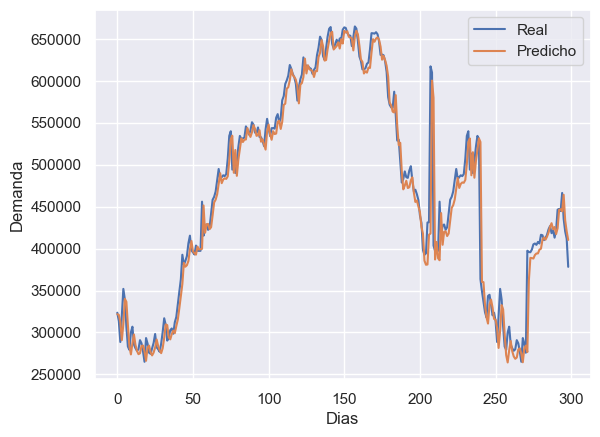

In [71]:
dataRNNdiasDemanda = data.copy()
scaler = MinMaxScaler(feature_range=(0, 1))
dataRNNdiasDemanda['Demanda'] = scaler.fit_transform(dataRNNdiasDemanda[['Demanda']])
timesteps = 30
x = []
y = []
for i in range(timesteps, len(dataRNNdiasDemanda)):
    x.append(dataRNNdiasDemanda[i-timesteps:i]['Demanda'].values)
    y.append(dataRNNdiasDemanda['Demanda'][i])
x = np.array(x)
y = np.array(y)
train_size = int(len(dataRNNdiasDemanda) * 0.7)
x_train = x[:train_size, :]
y_train = y[:train_size]
x_test = x[train_size:, :]
y_test = y[train_size:]
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
modelo.add(LSTM(50))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')
modelo.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
y_pred = modelo.predict(x_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
errorRNN = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNN = 100 - errorRNN
mseRNN = np.mean((y_pred - y_test)**2)
print(f"Precision de la RNN por días es: {accuracyRNN}" )
print(f"El error es: {errorRNN}")
print(f"El error cuadrático mse: {mseRNN} kW^2")
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Dias')
plt.ylabel('Demanda')
plt.legend()
plt.show()


## RNN por mes 

Ahora repetimos el proceso pero con algunos cambios y la frecuencia por meses

In [1]:
X = dataMes.drop("Demanda", axis=1)
y = dataMes["Demanda"]

NameError: name 'dataMes' is not defined

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X_train = X_train.reshape(-1, 1, X_train.shape[1])
X_test = X_test.reshape(-1, 1, X_test.shape[1])

In [ ]:
modelo = Sequential()
modelo.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
modelo.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

In [ ]:
train_loss = modelo.evaluate(X_train, y_train, verbose=0)
test_loss = modelo.evaluate(X_test, y_test, verbose=0)
print("Perdidas entreno:", train_loss)
print("Perdidas test :", test_loss)

In [ ]:
y_pred = modelo.predict(X_test)

In [ ]:
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [ ]:
plt.plot(y_test, label='Valor real')
plt.plot(y_pred, label='Predicción')
plt.legend()
plt.show()

In [ ]:
errorRNNM = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNNM = 100 - errorRNNM
mseRNNM = np.mean((y_pred - y_test)**2)

In [ ]:
print(f"Precision de la RNN por meses es: {accuracyRNNM}" )
print(f"El error es: {errorRNNM}")
print(f"El error cuadrático mse: {mseRNNM} kw")

## RNN por días solo demanda

In [94]:
dataRNNdiasDemanda = data.copy()

In [95]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataRNNdiasDemanda['Demanda'] = scaler.fit_transform(dataRNNdiasDemanda[['Demanda']])
timesteps = 30

In [96]:
x = []
y = []
for i in range(timesteps, len(dataRNNdiasDemanda)):
    x.append(dataRNNdiasDemanda[i-timesteps:i]['Demanda'].values)
    y.append(dataRNNdiasDemanda['Demanda'][i])

In [97]:
x = np.array(x)
y = np.array(y)

In [98]:
train_size = int(len(dataRNNdiasDemanda) * 0.7)
x_train = x[:train_size, :]
y_train = y[:train_size]
x_test = x[train_size:, :]
y_test = y[train_size:]

In [99]:
modelo = Sequential()
modelo.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
modelo.add(LSTM(50))
modelo.add(Dense(1))
modelo.compile(loss='mean_squared_error', optimizer='adam')

In [100]:
modelo.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)

In [101]:
y_pred = modelo.predict(x_test)

10/10 [==============================] - 1s 17ms/step


In [102]:
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [103]:
errorRNN = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracyRNN = 100 - errorRNN
mseRNN = np.mean((y_pred - y_test)**2)

In [104]:
print(f"Precision de la RNN por días es: {accuracyRNN}" )
print(f"El error es: {errorRNN}")
print(f"El error cuadrático mse: {mseRNN} kW")

Precision de la RNN por días es: 96.69473281891625
El error es: 3.3052671810837535
El error cuadrático mse: 619506916.1845442 kW


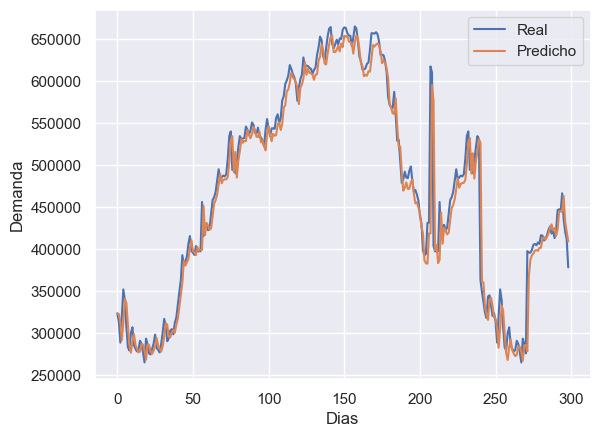

In [105]:
plt.plot(y_test, label='Real')
plt.plot(y_pred, label='Predicho')
plt.xlabel('Dias')
plt.ylabel('Demanda')
plt.legend()
plt.show()

## Predicción según meses

In [107]:
dataPredMes = data.copy()
dataPredMes

,Demanda,Produccion
fecha,,
2019-01-01,379726,289005
2019-01-02,383590,288843
2019-01-03,378901,283581
2019-01-04,378180,285621
2019-01-05,385805,283991
...,...,...
2021-12-26,466243,299610
2021-12-27,435243,291977
2021-12-28,420410,279246


In [233]:
data1_19_20 = dataPredMes[(dataPredMes.index.month == 4) & (dataPredMes.index.year <= 2020)]
data1_21 = dataPredMes[(dataPredMes.index.month == 1) & (dataPredMes.index.year == 2021)]

In [234]:
train_data  = data1_19_20
train_data = train_data.drop('Produccion', axis=1)
train_data

,Demanda
fecha,
2019-04-01,286390
2019-04-02,283185
2019-04-03,281100
2019-04-04,273165
2019-04-05,270548
2019-04-06,273851
2019-04-07,276671
2019-04-08,274952
2019-04-09,273243


In [190]:
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)

In [191]:
timesteps = 62

In [192]:

def create_sequences(data):
    X, y = [], []
    for i in range(len(data)-timesteps-1):
        X.append(data[i:(i+timesteps), 0])
        y.append(data[(i+timesteps), 0])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [193]:
X_train, y_train = create_sequences(train_data_scaled)

In [194]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

IndexError: tuple index out of range

In [163]:
model = Sequential()
model.add(LSTM(50, input_shape=(timesteps, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [164]:
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100
1/1 - 3s - loss: 0.1555 - 3s/epoch - 3s/step
Epoch 2/100
1/1 - 0s - loss: 0.1361 - 20ms/epoch - 20ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1191 - 22ms/epoch - 22ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1042 - 21ms/epoch - 21ms/step
Epoch 5/100
1/1 - 0s - loss: 0.0912 - 23ms/epoch - 23ms/step
Epoch 6/100
1/1 - 0s - loss: 0.0802 - 20ms/epoch - 20ms/step
Epoch 7/100
1/1 - 0s - loss: 0.0714 - 18ms/epoch - 18ms/step
Epoch 8/100
1/1 - 0s - loss: 0.0650 - 18ms/epoch - 18ms/step
Epoch 9/100
1/1 - 0s - loss: 0.0615 - 20ms/epoch - 20ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0613 - 18ms/epoch - 18ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0641 - 19ms/epoch - 19ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0676 - 16ms/epoch - 16ms/step
Epoch 13/100
1/1 - 0s - loss: 0.0693 - 19ms/epoch - 19ms/step
Epoch 14/100
1/1 - 0s - loss: 0.0686 - 15ms/epoch - 15ms/step
Epoch 15/100
1/1 - 0s - loss: 0.0663 - 17ms/epoch - 17ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0636 - 16ms/epoch - 16ms/step
Epoch 17/100
1/1 - 0s

In [165]:
last_data = train_data_scaled[-timesteps:]
pred_values = []
for i in range(31):
    test_data_seq = last_data[-timesteps:]
    test_data_seq = test_data_seq.reshape(1, timesteps, 1)
    pred = model.predict(test_data_seq)
    pred_values.append(pred[0][0])
    last_data = np.append(last_data, pred)[1:]

1/1 [==============================] - 0s 23ms/step


In [166]:
pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))

In [167]:
for i, value in enumerate(pred_values):
    print("La demanda para el día", i+1, "de enero de 2021 es:", value[0])

La demanda para el día 1 de enero de 2021 es: 258554.78
La demanda para el día 2 de enero de 2021 es: 257502.66
La demanda para el día 3 de enero de 2021 es: 256607.48
La demanda para el día 4 de enero de 2021 es: 255845.81
La demanda para el día 5 de enero de 2021 es: 255237.47
La demanda para el día 6 de enero de 2021 es: 254766.58
La demanda para el día 7 de enero de 2021 es: 254438.48
La demanda para el día 8 de enero de 2021 es: 254229.55
La demanda para el día 9 de enero de 2021 es: 254029.19
La demanda para el día 10 de enero de 2021 es: 253864.6
La demanda para el día 11 de enero de 2021 es: 253758.48
La demanda para el día 12 de enero de 2021 es: 253696.56
La demanda para el día 13 de enero de 2021 es: 253666.06
La demanda para el día 14 de enero de 2021 es: 253645.9
La demanda para el día 15 de enero de 2021 es: 253640.44
La demanda para el día 16 de enero de 2021 es: 253615.64
La demanda para el día 17 de enero de 2021 es: 253594.44
La demanda para el día 18 de enero de 2021

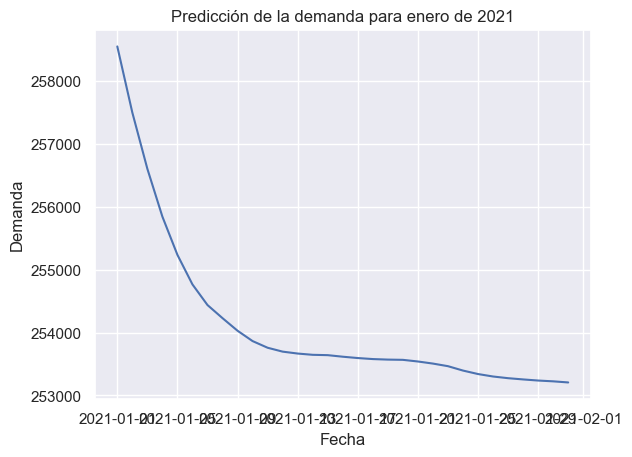

In [168]:
fechas = [datetime.date(2021, 1, i+1) for i in range(len(pred_values))]
plt.plot(fechas, pred_values)
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.title('Predicción de la demanda para enero de 2021')
plt.show()

In [235]:
def demanda_segun_mes(mes,look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data  = data1_19_20.copy()
    train_data = train_data.drop('Produccion', axis=1)
    train_data
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data  = data1_21.copy()
    val_data  = val_data .drop('Produccion', axis=1)
    val_data 
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    X, y = [], []
    for i in range(len(train_data_scaled)-timesteps-1):
        X.append(train_data_scaled[i:(i+timesteps), 0])
        y.append(train_data_scaled[(i+timesteps), 0])
    X_train = np.array(X)
    y_train = np.array(y)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(128, input_shape=(timesteps, 1), return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)
    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(look_back):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(fechas, val_data, label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()


    return pred_values

Epoch 1/100
1/1 - 5s - loss: 0.3730 - 5s/epoch - 5s/step
Epoch 2/100
1/1 - 0s - loss: 0.2716 - 63ms/epoch - 63ms/step
Epoch 3/100
1/1 - 0s - loss: 0.1903 - 57ms/epoch - 57ms/step
Epoch 4/100
1/1 - 0s - loss: 0.1299 - 52ms/epoch - 52ms/step
Epoch 5/100
1/1 - 0s - loss: 0.1052 - 48ms/epoch - 48ms/step
Epoch 6/100
1/1 - 0s - loss: 0.1311 - 51ms/epoch - 51ms/step
Epoch 7/100
1/1 - 0s - loss: 0.1402 - 51ms/epoch - 51ms/step
Epoch 8/100
1/1 - 0s - loss: 0.1227 - 53ms/epoch - 53ms/step
Epoch 9/100
1/1 - 0s - loss: 0.1048 - 55ms/epoch - 55ms/step
Epoch 10/100
1/1 - 0s - loss: 0.0963 - 47ms/epoch - 47ms/step
Epoch 11/100
1/1 - 0s - loss: 0.0954 - 46ms/epoch - 46ms/step
Epoch 12/100
1/1 - 0s - loss: 0.0978 - 47ms/epoch - 47ms/step
Epoch 13/100
1/1 - 0s - loss: 0.1003 - 47ms/epoch - 47ms/step
Epoch 14/100
1/1 - 0s - loss: 0.1012 - 50ms/epoch - 50ms/step
Epoch 15/100
1/1 - 0s - loss: 0.1002 - 50ms/epoch - 50ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0976 - 48ms/epoch - 48ms/step
Epoch 17/100
1/1 - 0s

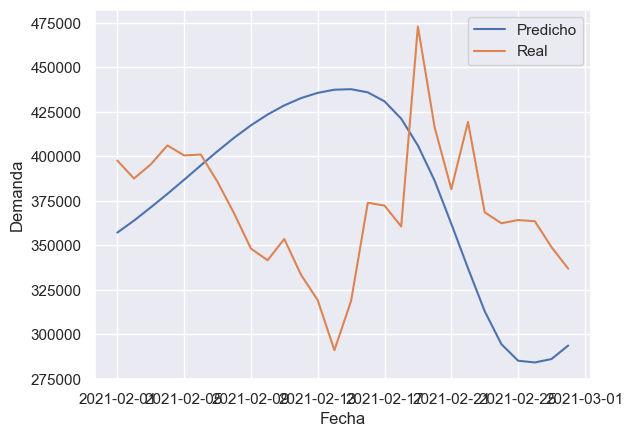

array([[357156.97],
       [363914.12],
       [371325.03],
       [378913.44],
       [386857.53],
       [394952.06],
       [402900.56],
       [410503.  ],
       [417445.22],
       [423524.1 ],
       [428666.94],
       [432750.53],
       [435696.28],
       [437478.  ],
       [437764.16],
       [435987.12],
       [430956.53],
       [421189.16],
       [406128.66],
       [386391.4 ],
       [362131.47],
       [337141.56],
       [312984.22],
       [294472.34],
       [285173.06],
       [284202.  ],
       [286113.47],
       [293704.72]], dtype=float32)

In [245]:
demanda_segun_mes(2,28)

In [242]:

def demanda_segun_mes2(mes, look_back):
    data1_19_20 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year <= 2020)]
    train_data = data1_19_20.drop('Produccion', axis=1)
    
    data1_21 = dataPredMes[(dataPredMes.index.month == mes) & (dataPredMes.index.year == 2021)]
    val_data = data1_21.drop('Produccion', axis=1)
    
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    
    X_train, y_train = [], []
    for i in range(len(train_data_scaled) - look_back - 1):
        X_train.append(train_data_scaled[i:(i + look_back), 0])
        y_train.append(train_data_scaled[(i + look_back), 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    layers = 1
    units = 128
    return_sequence = False
    recurrent_dropout = 0
    dense_dropout = 0.2
    dense_layers = [32, 64, 128]

    model = Sequential()
    model.add(LSTM(units, input_shape=(look_back, 1), return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in range(layers - 1):
        model.add(LSTM(units, return_sequences=return_sequence, recurrent_dropout=recurrent_dropout))
    for i in dense_layers:
        model.add(Dense(i, activation='relu'))
        model.add(Dropout(dense_dropout))
    model.add(Dense(1))

    optimizer = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    batch_size = 64
    epochs = 200
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2, shuffle=False)

    last_data = train_data_scaled[-look_back:]
    pred_values = []
    for i in range(len(val_data)):
        test_data_seq = last_data[-look_back:]
        test_data_seq = test_data_seq.reshape(1, look_back, 1)
        pred = model.predict(test_data_seq)
        pred_values.append(pred[0][0])
        last_data = np.append(last_data, pred)[1:]
    pred_values = scaler.inverse_transform(np.array(pred_values).reshape(-1, 1))
    fechas = [datetime.date(2021, mes, i+1) for i in range(len(pred_values))]
    plt.plot(fechas, pred_values, label='Predicho')
    plt.plot(val_data.index, val_data['Demanda'], label='Real')
    plt.xlabel('Fecha')
    plt.ylabel('Demanda')
    plt.legend()
    plt.show()

    return pred_values


Epoch 1/200
1/1 - 3s - loss: 0.3570 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 0.3339 - 34ms/epoch - 34ms/step
Epoch 3/200
1/1 - 0s - loss: 0.2953 - 38ms/epoch - 38ms/step
Epoch 4/200
1/1 - 0s - loss: 0.2564 - 37ms/epoch - 37ms/step
Epoch 5/200
1/1 - 0s - loss: 0.2290 - 35ms/epoch - 35ms/step
Epoch 6/200
1/1 - 0s - loss: 0.1873 - 34ms/epoch - 34ms/step
Epoch 7/200
1/1 - 0s - loss: 0.1458 - 36ms/epoch - 36ms/step
Epoch 8/200
1/1 - 0s - loss: 0.1373 - 34ms/epoch - 34ms/step
Epoch 9/200
1/1 - 0s - loss: 0.0997 - 37ms/epoch - 37ms/step
Epoch 10/200
1/1 - 0s - loss: 0.1103 - 37ms/epoch - 37ms/step
Epoch 11/200
1/1 - 0s - loss: 0.1543 - 35ms/epoch - 35ms/step
Epoch 12/200
1/1 - 0s - loss: 0.1455 - 43ms/epoch - 43ms/step
Epoch 13/200
1/1 - 0s - loss: 0.1022 - 32ms/epoch - 32ms/step
Epoch 14/200
1/1 - 0s - loss: 0.1076 - 30ms/epoch - 30ms/step
Epoch 15/200
1/1 - 0s - loss: 0.0927 - 31ms/epoch - 31ms/step
Epoch 16/200
1/1 - 0s - loss: 0.1012 - 38ms/epoch - 38ms/step
Epoch 17/200
1/1 - 0s

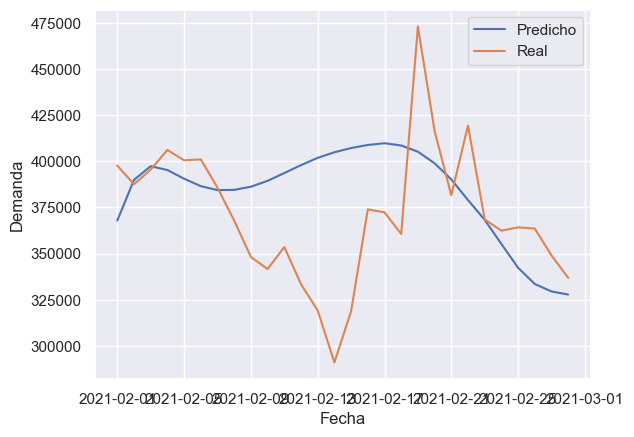

array([[367924.47],
       [389946.7 ],
       [397349.03],
       [395276.38],
       [390564.6 ],
       [386556.2 ],
       [384395.1 ],
       [384531.62],
       [386243.72],
       [389421.7 ],
       [393630.4 ],
       [397942.25],
       [401870.72],
       [404898.1 ],
       [407188.2 ],
       [408839.5 ],
       [409799.8 ],
       [408577.  ],
       [405196.12],
       [398946.5 ],
       [390177.5 ],
       [379021.66],
       [368295.53],
       [355223.12],
       [342360.8 ],
       [333547.38],
       [329540.66],
       [327840.78]], dtype=float32)

In [244]:
demanda_segun_mes2(2, 28)

## RNN teniendo en cuenta solo 2019 y 2020

11/11 [==============================] - 1s 13ms/step
MAPE: 3.34%
MSE: 637604014.51 kW^2


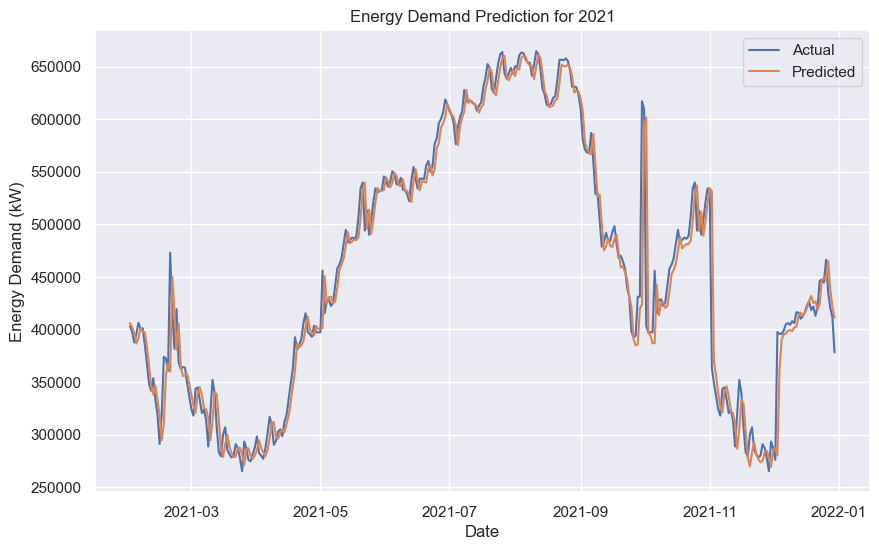

In [117]:


data1_19_20 = dataPredMes[ (dataPredMes.index.year <= 2020)]
train_data = data1_19_20.drop('Produccion', axis=1)    
data1_21 = dataPredMes[ (dataPredMes.index.year == 2021)]
val_data = data1_21.drop('Produccion', axis=1)

scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)

timesteps = 30
n_features = 1

def create_sequences(data, timesteps):
    X = []
    y = []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_scaled, timesteps)
X_val, y_val = create_sequences(val_data_scaled, timesteps)

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, n_features)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

y_pred_scaled = model.predict(X_val)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_val = scaler.inverse_transform(y_val)

mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
mse = np.mean((y_pred - y_val)**2)

print(f"MAPE: {mape:.2f}%")
print(f"MSE: {mse:.2f} kW^2")

y_pred_reshaped = y_pred.reshape(-1)
val_data_trunc = val_data.iloc[timesteps:]

plt.figure(figsize=(10, 6))
plt.plot(val_data_trunc.index, y_val, label='Actual')
plt.plot(val_data_trunc.index, y_pred_reshaped, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Energy Demand (kW)')
plt.title('Energy Demand Prediction for 2021')
plt.legend()
plt.show()

In [115]:
train_data

,Demanda
fecha,
2019-01-01,379726
2019-01-02,383590
2019-01-03,378901
2019-01-04,378180
2019-01-05,385805
...,...
2020-12-27,400978
2020-12-28,398717
2020-12-29,397432


In [116]:
val_data

,Demanda
fecha,
2021-01-01,398854
2021-01-02,405037
2021-01-03,406001
2021-01-04,404353
2021-01-05,407859
...,...
2021-12-26,466243
2021-12-27,435243
2021-12-28,420410
